**Purpose**: Implements a custom embedding model from scratch
- Builds a simple embedding model using PyTorch
- Uses averaged word embeddings approach
- Demonstrates how scaling affects learned embeddings
- Includes custom dataset and dataloader implementation
- Shows raw embedding behavior without pre-trained knowledge

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

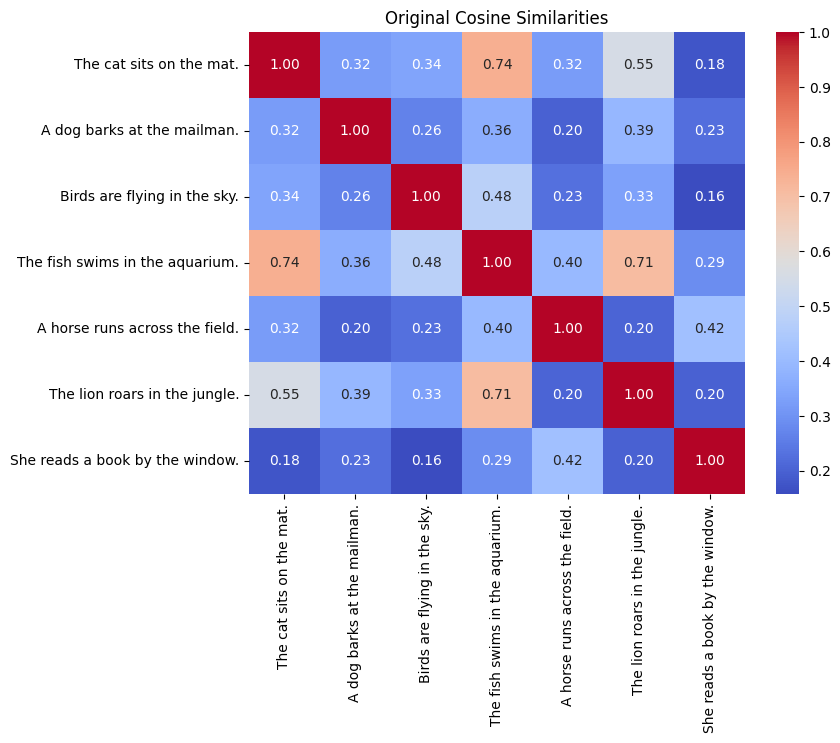

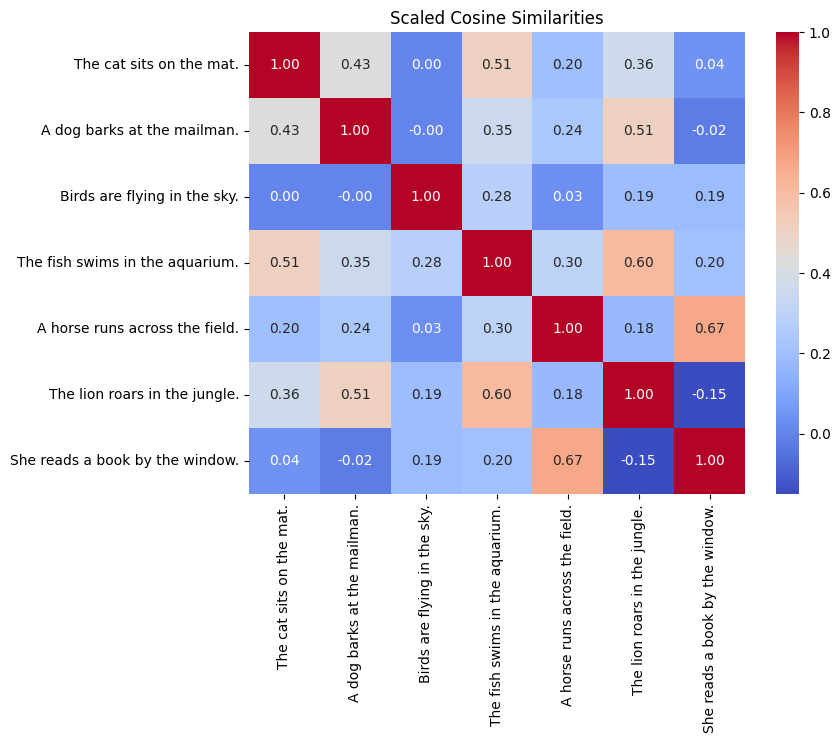

Sentence: 'The cat sits on the mat.'
Top similar sentences (original):
  'The fish swims in the aquarium.' with score 0.7415
  'The lion roars in the jungle.' with score 0.5537
Top similar sentences (scaled):
  'The fish swims in the aquarium.' with score 0.5109
  'A dog barks at the mailman.' with score 0.4314
------------------------------------------------------------
Sentence: 'A dog barks at the mailman.'
Top similar sentences (original):
  'The lion roars in the jungle.' with score 0.3907
  'The fish swims in the aquarium.' with score 0.3638
Top similar sentences (scaled):
  'The lion roars in the jungle.' with score 0.5113
  'The cat sits on the mat.' with score 0.4314
------------------------------------------------------------
Sentence: 'Birds are flying in the sky.'
Top similar sentences (original):
  'The fish swims in the aquarium.' with score 0.4798
  'The cat sits on the mat.' with score 0.3389
Top similar sentences (scaled):
  'The fish swims in the aquarium.' with score

In [6]:

# Step 1: Prepare the Dataset
sentences = [
    "The cat sits on the mat.",
    "A dog barks at the mailman.",
    "Birds are flying in the sky.",
    "The fish swims in the aquarium.",
    "A horse runs across the field.",
    "The lion roars in the jungle.",
    "She reads a book by the window."
]
labels = [0, 1, 2, 3, 4, 5, 6]

# Step 2: Create a Vocabulary and Encode Sentences
all_text = ' '.join(sentences)
word_counts = Counter(all_text.lower().split())
vocab = {word: idx+1 for idx, (word, _) in enumerate(word_counts.items())}  # Start from 1
vocab_size = len(vocab) + 1  # Plus one for padding index 0

def encode_sentence(sentence, vocab):
    return [vocab[word] for word in sentence.lower().split()]

encoded_sentences = [encode_sentence(s, vocab) for s in sentences]

# Step 3: Create a Custom Dataset
class TextDataset(Dataset):
    def __init__(self, encoded_sentences, labels):
        self.encoded_sentences = [torch.tensor(s, dtype=torch.long) for s in encoded_sentences]
        self.labels = labels

    def __len__(self):
        return len(self.encoded_sentences)

    def __getitem__(self, idx):
        return self.encoded_sentences[idx], self.labels[idx]

dataset = TextDataset(encoded_sentences, labels)

# Step 4: Define a Custom Collate Function
def collate_fn(batch):
    inputs = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Pad the sequences
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)

    # Convert targets to tensor
    targets_tensor = torch.tensor(targets, dtype=torch.long)

    return inputs_padded, targets_tensor

# Step 5: DataLoader with Custom Collate Function
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Step 6: Define the Embedding Model
class SimpleEmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SimpleEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

    def forward(self, x):
        # x shape: [batch_size, seq_length]
        embedded = self.embedding(x)  # [batch_size, seq_length, embedding_dim]

        # Create a mask to ignore padding indices
        mask = (x != 0).unsqueeze(-1).float()  # [batch_size, seq_length, 1]

        # Apply mask to embeddings
        masked_embedded = embedded * mask

        # Compute the sum of embeddings and divide by the number of valid tokens
        summed = masked_embedded.sum(dim=1)  # [batch_size, embedding_dim]
        lengths = mask.sum(dim=1)  # [batch_size, 1]

        # Avoid division by zero
        lengths[lengths == 0] = 1

        averaged = summed / lengths  # [batch_size, embedding_dim]

        return averaged

# Step 7: Training Parameters
embedding_dim = 50
num_epochs = 20
learning_rate = 0.01

# Step 8: Initialize Model, Loss Function, Optimizer
model = SimpleEmbeddingModel(vocab_size, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Step 9: Training Loop
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Step 10: Extract Embeddings
model.eval()
with torch.no_grad():
    sentence_embeddings = []
    for idx in range(len(sentences)):
        input_tensor = torch.tensor(encoded_sentences[idx], dtype=torch.long).unsqueeze(0)
        embedding = model(input_tensor)
        sentence_embeddings.append(embedding.numpy()[0])
sentence_embeddings = np.array(sentence_embeddings)

# Step 11: Compute Original Cosine Similarities
original_cosine_similarities = cosine_similarity(sentence_embeddings)

# Step 12: Introduce Scaling into Embeddings
scaling_factors = np.ones(embedding_dim)
scaling_factors[:embedding_dim // 2] = 0.01
scaling_factors[embedding_dim // 2:] = 100

scaled_embeddings = sentence_embeddings * scaling_factors

# Step 13: Compute Scaled Cosine Similarities
scaled_cosine_similarities = cosine_similarity(scaled_embeddings)

# Step 14: Visualize Cosine Similarities
def plot_similarity_matrix(similarity_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', fmt=".2f",
                xticklabels=sentences, yticklabels=sentences)
    plt.title(title)
    plt.show()

plot_similarity_matrix(original_cosine_similarities, "Original Cosine Similarities")
plot_similarity_matrix(scaled_cosine_similarities, "Scaled Cosine Similarities")

# Step 15: Observe Changes in Rankings
for idx, sentence in enumerate(sentences):
    print(f"Sentence: '{sentence}'")
    
    original_scores = original_cosine_similarities[idx]
    original_rankings = np.argsort(-original_scores)
    print("Top similar sentences (original):")
    for i in original_rankings[1:3]:
        print(f"  '{sentences[i]}' with score {original_scores[i]:.4f}")
    
    scaled_scores = scaled_cosine_similarities[idx]
    scaled_rankings = np.argsort(-scaled_scores)
    print("Top similar sentences (scaled):")
    for i in scaled_rankings[1:3]:
        print(f"  '{sentences[i]}' with score {scaled_scores[i]:.4f}")
    
    print("-" * 60)